<a href="https://colab.research.google.com/github/ajayostawal/Classification/blob/main/IBM_Employee_Attrition_imbalance_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import packages

import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import where
from pprint import pprint
from scipy import stats
from collections import Counter

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, recall_score, confusion_matrix, \
precision_score, f1_score, accuracy_score, classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv('/content/hr-attrition.csv')

In [3]:
data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,0,3,2,Sales Executive,4,Single,5993,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,1,2,2,Research Scientist,2,Married,5130,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,1,2,1,Laboratory Technician,3,Single,2090,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,0,3,1,Research Scientist,3,Married,2909,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,1,3,1,Laboratory Technician,2,Married,3468,9,0,12,3,4,1,6,3,3,2,2,2,2


In [4]:
data1 = pd.get_dummies(data, columns=None)


In [5]:
data1.head()

,Age,Attrition,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1,2,2,0,3,2,4,5993,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,0,8,1,3,1,2,2,2,5130,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1,2,2,4,1,2,1,3,2090,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,0,3,4,4,0,3,1,3,2909,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,0,2,1,1,1,3,1,2,3468,9,0,12,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [7]:
scaler = MinMaxScaler()
df = scaler.fit_transform(data1.values)
scaled = pd.DataFrame(df, columns=data1.columns)

# There are now 47 features, since we broke down categorical vars
scaled.tail()

,Age,Attrition,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
1465,0.428571,0.0,0.785714,0.25,0.666667,1.0,1.000000,0.25,1.000000,0.082254,0.444444,0.0,0.428571,0.0,0.666667,0.333333,0.425,0.500000,0.666667,0.125,0.111111,0.000000,0.176471,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,0.500000,0.0,0.178571,0.00,1.000000,1.0,0.333333,0.50,0.000000,0.472986,0.444444,0.0,0.285714,0.0,0.000000,0.333333,0.225,0.833333,0.666667,0.175,0.388889,0.066667,0.411765,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,0.214286,0.0,0.107143,0.50,0.333333,1.0,1.000000,0.25,0.333333,0.270300,0.111111,1.0,0.642857,1.0,0.333333,0.333333,0.150,0.000000,0.666667,0.150,0.111111,0.000000,0.176471,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,0.738095,0.0,0.035714,0.50,1.000000,1.0,0.333333,0.25,0.333333,0.230700,0.222222,0.0,0.214286,0.0,1.000000,0.000000,0.425,0.500000,0.333333,0.225,0.333333,0.000000,0.470588,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1469,0.380952,0.0,0.250000,0.50,0.333333,1.0,1.000000,0.25,0.666667,0.178778,0.222222,0.0,0.071429,0.0,0.000000,0.000000,0.150,0.500000,1.000000,0.100,0.166667,0.066667,0.117647,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


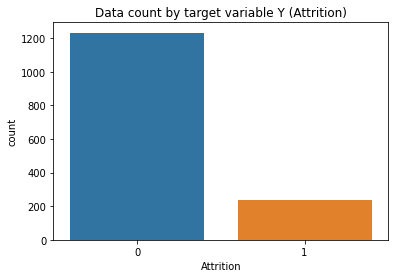

In [8]:
sns.countplot(x=data1['Attrition'])
plt.title('Data count by target variable Y (Attrition)')
plt.show()

In [9]:
# Samples where target var = 1 
a_1s = data1[data1.Attrition == 1]

print("Percentage of 1s: {0:.0%}".format(round(a_1s.shape[0]/data1.shape[0], 2)))
print('Total Attrition = 1:', a_1s.shape[0])
print('Total samples:', data1.shape[0])

Percentage of 1s: 16%
Total Attrition = 1: 237
Total samples: 1470


In [10]:
attrition = data1['Attrition']
scaled_df = scaled.drop(columns=['Attrition'])

x_train, x_test, y_train, y_test = train_test_split(scaled_df,
                                                    attrition,
                                                    test_size=0.25,
                                                    random_state=1,
                                                    stratify=attrition)

In [11]:
print('X train set shape:', x_train.shape)
print('Y train set shape:', y_train.shape)
print('X test set shape:', x_test.shape)
print('Y test set shape:', y_test.shape)

X train set shape: (1102, 46)
Y train set shape: (1102,)
X test set shape: (368, 46)
Y test set shape: (368,)


In [12]:
#Decision tree model 
dt_model = DecisionTreeClassifier(class_weight='balanced')
dt_model.fit(x_train,y_train)

#XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(x_train,y_train)

#Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

print()

In [13]:
def cross_val(model, scoring, x_test, y_test):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  scores = cross_val_score(model, x_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)
  return np.mean(scores)

def results(model, name, x_test, y_test, verbose=True):
  scorers_lst = ['recall', 'precision', 'f1']

  scores = [] # cross validated scores on three metrics
  for i in scorers_lst:
    scores.append(cross_val(model, i, x_test, y_test))
  
  if verbose:
    print('Recall for', name, round(scores[0], 4))
    print('Precision for', name, round(scores[1], 4))
    print('F1 for', name, round(scores[2], 4))
    print()
  else:
    return scores

In [14]:
models = {'Decision Tree': dt_model,
          'XGBoost': xgb_model,
          'Logistic Regression': lr_model}

for key in models:
  results(models[key], key, x_test, y_test)

Recall for Decision Tree 0.3707
Precision for Decision Tree 0.3515
F1 for Decision Tree 0.3531

Recall for XGBoost 0.3449
Precision for XGBoost 0.6346
F1 for XGBoost 0.4311

Recall for Logistic Regression 0.3616
Precision for Logistic Regression 0.7039
F1 for Logistic Regression 0.4601



In [16]:
# Adopted the wrapper function from Arvai, K. (2018)

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='recall_score', clf=None, grid=None):

    """
    Fits a GridSearchCV classifier using refit_score for optimization.
    Prints classifier performance metrics.
    """
    
    # Applying k-fold to GridSearch
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(x_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data
    print('\nConfusion matrix of DT optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [17]:
#Decision tree
print('Current Deciscion Tree parameters:\n')
pprint(dt_model.get_params())

Current Deciscion Tree parameters:

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}


In [18]:
# Please refer to the DecisionTreeClassifier() documentation
# for the details regarding each parameter

dt_param_grid = {'criterion': ['gini', 'entropy'],
           'max_features': ['auto', 'sqrt', 'log2'],
           'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
           'min_samples_split': [2, 5],
           'min_samples_leaf': [1, 2],
           'random_state': [0]
}

grid_search_dt = grid_search_wrapper(refit_score='recall_score',
                                      grid=dt_param_grid, clf=dt_model)

Best params for recall_score
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}

Confusion matrix of DT optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       234        75
pos        29        30


In [19]:
#XGBoost
print('Current XGBoost parameters:\n')
pprint(xgb_model.get_params())

Current XGBoost parameters:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


In [20]:
# Please refer to the XGBClassifier() documentation
# for the details regarding each parameter

xgb_param_grid = {'n_estimators': [100, 200],
                  'booster': ['gbtree', 'dart'],
                  'learning_rate': [0.25, 0.3, 0.35, 0.4] ,
                  'max_depth': [3, 4],
                  'gamma': [0.0, 0.1],
                  'colsample_bytree': [0.4]}

grid_search_xgb = grid_search_wrapper(refit_score='recall_score',
                                        grid=xgb_param_grid, clf=xgb_model)

Best params for recall_score
{'booster': 'gbtree', 'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 200}

Confusion matrix of DT optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       282        27
pos        29        30


In [21]:
#Logistic Regression
print('Current Logistic Regression parameters:\n')
pprint(lr_model.get_params())

Current Logistic Regression parameters:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [22]:
# Please refer to the XGBClassifier() documentation
# for the details regarding each parameter

lr_param_grid = {'C': [0.1, 1, 10],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'max_iter': [300, 500, 700],
                 'random_state': [0]
}

grid_search_lr = grid_search_wrapper(refit_score='recall_score',
                                        grid=lr_param_grid, clf=lr_model)

Best params for recall_score
{'C': 10, 'max_iter': 300, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}

Confusion matrix of DT optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       293        16
pos        30        29


In [23]:
# Parameters to be printed in the Results table for each tuned model 

tuned_params = {'Decision Tree': (grid_search_dt, ['mean_test_precision_score',
                                  'mean_test_recall_score', 'mean_test_accuracy_score',
                                  'param_criterion', 'param_max_depth',
                                  'param_max_features', 'param_min_samples_split',
                                  'param_min_samples_leaf']),
                'XGBoost': (grid_search_xgb, ['mean_test_precision_score',
                            'mean_test_recall_score', 'mean_test_accuracy_score',
                            'param_booster', 'param_gamma', 'param_learning_rate',
                            'param_max_depth', 'param_n_estimators']),
                'Logistic Regression': (grid_search_lr, ['mean_test_precision_score',
                                        'mean_test_recall_score','mean_test_accuracy_score',
                                        'param_C', 'param_penalty','param_solver',
                                        'param_max_iter'])}

In [24]:
def tuning_res(wrapper_res, params):
  res = pd.DataFrame(wrapper_res.cv_results_)
  res = res.sort_values(by='mean_test_recall_score', ascending=False)
  display(res[params].round(3).head(3))

In [25]:
for key in tuned_params:
  print('Top 3 Optimal Parameter Combinations for', key)
  tuning_res(tuned_params[key][0], tuned_params[key][1])
  print()

Top 3 Optimal Parameter Combinations for Decision Tree


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_min_samples_leaf
142,0.280,0.465,0.711,entropy,10,log2,2,2
11,0.268,0.454,0.706,gini,10,log2,5,2
143,0.257,0.449,0.697,entropy,10,log2,5,2



Top 3 Optimal Parameter Combinations for XGBoost


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_booster,param_gamma,param_learning_rate,param_max_depth,param_n_estimators
29,0.687,0.427,0.875,gbtree,0.1,0.4,3,200
15,0.656,0.421,0.870,gbtree,0,0.4,4,200
41,0.714,0.421,0.878,dart,0,0.35,3,200



Top 3 Optimal Parameter Combinations for Logistic Regression


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_C,param_penalty,param_solver,param_max_iter
129,0.746,0.42,0.882,10,l2,saga,700
111,0.732,0.42,0.881,10,l2,lbfgs,500
92,0.705,0.42,0.877,10,l1,liblinear,300


In [26]:
y_aug = copy.deepcopy(attrition.values)
x_aug = copy.deepcopy(scaled_df.values)

X_train, X_test, y_train, y_test = train_test_split(x_aug, y_aug, 
                                                    stratify=attrition)

Counter({0: 924, 1: 178})



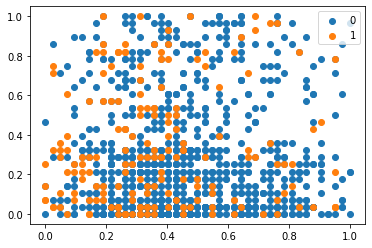

In [27]:
# Adopted parts of code from Brownlee, J. (2020).

# Class distribution summary
counter = Counter(y_train)
print(counter)
print()

# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 924, 1: 924})


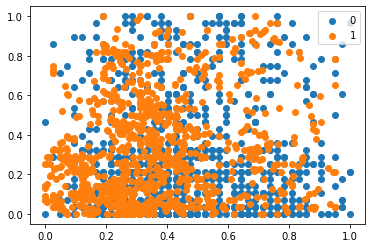

In [28]:
# transform the dataset
smt = SMOTE(random_state=0)
X_train_aug, y_train_aug = smt.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_aug)
print(counter)

# See how the SMOTE classifier has transformed the training set
for label, _ in counter.items():
	row_ix = where(y_train_aug == label)[0]
	plt.scatter(X_train_aug[row_ix, 0], X_train_aug[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [29]:
classifiers = {'DT': DecisionTreeClassifier(class_weight='balanced'),
               'XGB': XGBClassifier(),
               'LR': LogisticRegression(max_iter=500)}

def aug_pipeline(clf, clf_name, X_train, y_train, X_test, y_test, smt):
  pipeline = Pipeline([('smt', smt), ('clf_name', clf)])
  pipeline.fit(X_train, y_train)
  return (results(pipeline, clf_name, X_test, y_test, verbose=True))

In [30]:
print('Scores for basic models, trained on augmented balanced data:\n')

for key in classifiers:
  aug_pipeline(classifiers[key], key, X_train, y_train, X_test, y_test, smt)

Scores for basic models, trained on augmented balanced data:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Recall for DT 0.2611
Precision for DT 0.2248
F1 for DT 0.2371



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Recall for XGB 0.25
Precision for XGB 0.4319
F1 for XGB 0.3039



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Recall for LR 0.6167
Precision for LR 0.3347
F1 for LR 0.4313



In [31]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
importance = lr.coef_[0]


In [32]:
merged_list = [(list(scaled_df.columns)[i],importance[i]) for i in range(0, len((list(scaled_df.columns))))]
sorted_imp = sorted(merged_list, key=lambda x: x[-1], reverse=True)
sorted_imp[:10]

[('OverTime', 1.8289103138609497),
 ('YearsSinceLastPromotion', 1.7632208027144842),
 ('NumCompaniesWorked', 1.6438375386924355),
 ('DistanceFromHome', 1.0642940819912938),
 ('JobRole_Laboratory Technician', 0.7648270864770905),
 ('BusinessTravel_Travel_Frequently', 0.7573714180484191),
 ('JobRole_Sales Representative', 0.6300037783982655),
 ('MaritalStatus_Single', 0.5253822562328045),
 ('EducationField_Technical Degree', 0.4945281104636826),
 ('Gender', 0.46212762473802876)]

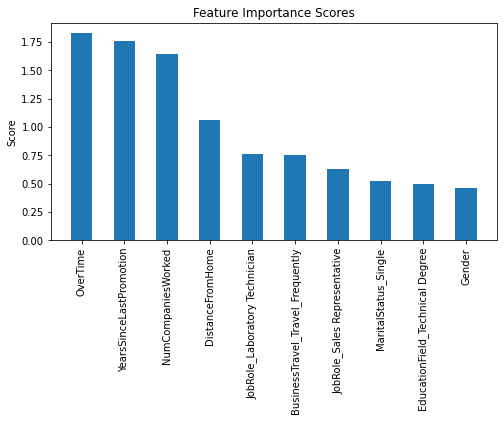

In [33]:
# ax setup adopted from Hunter et al. (2020)

labels = [i[0] for i in sorted_imp[:10]]
scores_lst = [i[1] for i in sorted_imp[:10]]
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x, scores_lst, 0.5)
ax.set_ylabel('Score')
ax.set_title('Feature Importance Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.show()